In [154]:
# !pip install rdkit-pypi
# !git clone https://github.com/molecularsets/moses.git

import matplotlib as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import re

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from rdkit import Chem

In [155]:
import csv

def load_smiles_from_csv(path, split_type='train'):
    '''
    Loads SMILES strings from a CSV file.

    Args:
        path (str): Path to the CSV file
        split_type (str): Split type ('train' or 'test')

    Returns:
        list: List of SMILES strings
    '''
    smiles = []
    with open(path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['SPLIT'].strip().lower() == split_type:
                smiles.append(row['SMILES'].strip())
    return smiles

In [156]:
'''
Functions are from the RNN model we have but not entirely sure where they would fit in the VAE
Currently working on implementation, the process_smiles function may help in creating valid molecules
'''

# Function to add start and end tokens
def process_smiles(smiles_list):
    return ["^" + s + "$" for s in smiles_list]


In [157]:
def extract_unique_atoms(smiles_list):
    unique_atoms = set()

    for smiles in smiles_list:
        # Parse the SMILES string
        molecule = Chem.MolFromSmiles(smiles)

        # If the molecule is valid, extract the atoms
        if molecule:
            for atom in molecule.GetAtoms():
                # Get the atom symbol and add it to the set
                unique_atoms.add(atom.GetSymbol())

    # Convert the set of unique atoms to a list and return it
    return list(unique_atoms)

def tokenize_smiles(smiles):
    """
    Tokenizes a SMILES string into meaningful tokens.
    Handles multi-character atoms like Cl and Br.
    """
    regex = r"""
        Cl|Br|                         # Two-character atoms
        \[[^\[\]]*?\]|                # Bracket expressions [NH4+], [C@H], etc.
        \%\d{2}|                      # Ring numbers like %10
        \d|                           # Ring closures 1-9
        =|#|-|\+|\\|/|\.|:|~|         # Bonds and stereochemistry
        [A-Za-z]|                     # Single-letter atoms
        [\(\)]                        # Branches
    """
    pattern = re.compile(regex, re.X)
    return pattern.findall(smiles)
def extract_unique_tokens(smiles_list):
    """
    Extract unique tokens from a list of SMILES strings.
    Handles multi-character atoms (Cl, Br), symbols, etc.
    """
    unique_tokens = set()
    for smiles in smiles_list:
        tokens = tokenize_smiles(smiles)
        unique_tokens.update(tokens)
    return sorted(unique_tokens)

def clean_smiles(smiles):
    '''
    Cleans a SMILES string by removing unwanted characters.

    Args:
        smiles (str): SMILES string

    Returns:
        str: Cleaned SMILES string
    '''
    # Remove unwanted metadata and special characters
    cleaned = smiles.split(',')[0].strip()
    cleaned = cleaned.replace('#', '')  # Remove '#' characters
    cleaned = cleaned.replace('$', '')  # Remove '$' characters
    cleaned = cleaned.replace('^', '')  # Remove '^' characters if present
    return cleaned

# trying out start and end characters
def decode_smiles(one_hot_tensor, idx_to_char):
    '''
    Decodes a one-hot encoded tensor back to a SMILES string, stopping at the end token.
    '''
    smiles = ''
    one_hot_tensor = one_hot_tensor.view(-1, len(idx_to_char))
    for row in one_hot_tensor:
        idx = row.argmax().item()
        char = idx_to_char[idx]
        if char == '$' and len(smiles) > 0:  # End of sequence
            break
        if char != '^':  # Skip start token
            smiles += char
    return smiles.strip()

def verify_smiles(smiles):
  '''
  Verifies the validity of a SMILES string using RDKit.

  Args:
      smiles (str): SMILES string to verify

  Returns:
      bool: True if valid, False otherwise
  '''
  mol = Chem.MolFromSmiles(smiles)
  return mol is not None

In [158]:
# Generate a new molecule from VAE by sampling from the latent space
def generate_smiles(model, latent_dim, idx_to_char, char_to_idx, max_length, temperature=1.0):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        # 1. Sample latent vector
        z = torch.randn(1, latent_dim).to(device)
        z_projected = model.projection_layer(z)
        z_flow, _ = model.flow(z_projected)
        z_flow_vae_compatible = model.flow_to_vae_projection(z_flow)

        # 2. Generate character-by-character
        generated_indices = []
        input_sequence = []

        current_char = '^'  # Start token
        for t in range(max_length):
            # Encode current input sequence to one-hot (if needed)
            input_seq = [char_to_idx.get(c, 0) for c in input_sequence + [current_char]]
            one_hot = torch.zeros(max_length, len(char_to_idx), device=device)
            for i, idx in enumerate(input_seq):
                one_hot[i, idx] = 1.0

            one_hot = one_hot.view(1, -1)  # Flatten for VAE

            # Forward through decoder using latent
            decoder_output = model.vae.decode(z_flow_vae_compatible)

            # Get distribution for the current position
            probs = F.softmax(
                decoder_output.view(max_length, len(char_to_idx))[t] / temperature,
                dim=-1
            )

            if t >= 0:
                probs[char_to_idx['^']] = 0.0
                #probs[char_to_idx['_']] = 0.0
                probs = probs / probs.sum()

            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char.get(next_char_idx, '')

            if next_char == '$':
                break

            generated_indices.append(next_char_idx)
            input_sequence.append(current_char)
            current_char = next_char

        generated_smiles = ''.join([idx_to_char.get(i, '') for i in generated_indices])
            # Verification using rdkit
        is_valid = verify_smiles(generated_smiles)
        if is_valid:
            return generated_smiles
        else:
            return "INVALID"

        # return generated_smiles


In [159]:
# Dataset class for SMILES strings

# Contemplate Protein To Vector Encoding
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, max_length=70, char_to_idx=None):
        '''
        Initializes the SMILESDataset with a list of SMILES strings.

        Args:
            smiles_list (list): List of SMILES strings
            max_length (int): Maximum length of the SMILES strings
            char_to_idx (dict): Character-to-index mapping

        The dataset will one-hot encode each character in a SMILES string to a fixed-size tensor of shape (max_length * vocab_size).
        If a SMILES string is shorter than max_length, it will be padded with zeros. If longer, it will be truncated.
        '''
        self.smiles_list = smiles_list
        self.max_length = max_length

        if char_to_idx is None:
            raise ValueError("Please provide a fixed character-to-index mapping")
            # self.char_to_idx, self.idx_to_char = build_vocabulary(smiles_list)
        else:
            self.char_to_idx = char_to_idx
            self.idx_to_char = {v: k for k, v in char_to_idx.items()}

        self.vocab_size = len(self.char_to_idx)

        original_count = len(smiles_list)
        filtered = []
        invalid_count = 0

        for s in smiles_list:
            s = s.strip()
            if all(c in self.char_to_idx for c in s):
                filtered.append(s)
            else:
                invalid_count += 1
        print(f"Total: {original_count}, Valid: {len(filtered)}, Invalid: {invalid_count}")
        self.smiles_list = filtered

    def __len__(self):
        '''
        Returns:
            int: Number of valid SMILES strings in the dataset
        '''

        return len(self.smiles_list)

    def __getitem__(self, idx):
        '''
        Fetches the encoded version of a SMILES string at a given index.

        Args:
            idx (int): Index of the SMILES string to retrieve

        Returns:
            torch.Tensor: One-hot encoded tensor of the SMILES string of shape (max_length * vocab_size)
        '''

        smiles = self.smiles_list[idx]

        # One-hot encode the SMILES string
        encoded = torch.zeros(self.max_length, self.vocab_size)
        for i, char in enumerate(smiles[:self.max_length]):
            encoded[i, self.char_to_idx[char]] = 1.0

        return encoded.view(-1) #Flatten into 1D tensor


In [160]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        if input_dim % 2 != 0:
            input_dim += 1

        self.net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2 * 2)
        )

        # Initialize last layer with zeros for stable training
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)

        # Get scaling and translation factors
        st = self.net(x1)
        s, t = st.chunk(2, dim=1)

        # Apply scaling with numerical stability
        scale_factor = 0.001
        s = torch.tanh(s) * scale_factor

        # Compute log determinant (only from the scaling part)
        log_det = torch.sum(s, dim=1)

        if reverse:
            # Inverse transformation
            x2 = (x2 - t) * torch.exp(-s)
            return torch.cat([x1, x2], dim=1), -log_det
        else:
            # Forward transformation
            x2 = x2 * torch.exp(s) + t
            return torch.cat([x1, x2], dim=1), log_det

class Flow(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim + (input_dim % 2)

        # Coupling layers without batch norm
        self.layers = nn.ModuleList([
            AffineCouplingLayer(self.input_dim, hidden_dim)
            for _ in range(num_layers)
        ])

        # Layer normalization instead of batch norm
        self.norms = nn.ModuleList([
            nn.LayerNorm(self.input_dim)
            for _ in range(num_layers)
        ])

    def forward(self, x, reverse=False):
        # Initialize log determinant
        log_det_total = torch.zeros(x.size(0), device=x.device)

        # Handle odd dimensions
        if x.size(1) % 2 != 0:
            x = F.pad(x, (0, 1), 'constant', 0)

        # Process through layers
        if reverse:
            for layer, norm in zip(reversed(self.layers), reversed(self.norms)):
                x = norm(x)
                x, log_det = layer(x, reverse=True)
                log_det_total = log_det_total + log_det
        else:
            for layer, norm in zip(self.layers, self.norms):
                #x.norm()
                x = norm(x)
                x, log_det = layer(x, reverse=False)
                log_det_total = log_det_total + log_det

        return x, log_det_total

    def get_latent(self, x):
        """Generate latent representation"""
        z, _ = self.forward(x)
        return z

In [161]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, vocab_size):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        # self.fc1 = nn.Linear(input_dim, 256)
        # self.fc_mu = nn.Linear(256, latent_dim)
        # self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)


    # def encode(self, x):
    #     h1 = F.relu(self.fc1(x))
    #     return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # mu, logvar = self.encode(x.view(-1, self.input_dim))
        # z = self.reparameterize(mu, logvar)

        recon_x = self.decode(x)
        # return recon_x, mu, logvar
        return recon_x, None, None

In [162]:
def compute_vae_loss(recon_x, x, mu, logvar, dataset):
    """
    Compute VAE loss with dataset-specific vocabulary size.

    Args:
        recon_x: Reconstructed input from VAE
        x: Original input data
        mu: Mean from VAE encoder
        logvar: Log variance from VAE encoder
        dataset: Dataset object containing vocab_size and max_length
    """
    batch_size = x.size(0)
    vocab_size = dataset.vocab_size
    seq_len = dataset.max_length

    # Reshape tensors to match dataset dimensions
    x = x.view(batch_size, seq_len * vocab_size)
    recon_x = recon_x.view(batch_size, seq_len * vocab_size)

    # Reconstruction loss (BCE)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # skip KL divergence when using FLOW latent space
    if mu is None or logvar is None:
        return BCE

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Weight the KLD term
    beta = 0.1  # Adjust this weight to balance reconstruction vs. KLD

    return BCE + beta * KLD

In [163]:
# Load SMILES strings
#with open('dataset/train.txt', 'r') as f:
    #smiles_train = [line.strip() for line in f][1:]

#with open('dataset/test.txt', 'r') as f:
     #smiles_test = [line.strip() for line in f]

# dataset/train.txt
smiles_train = load_smiles_from_csv('dataset/train.txt', split_type='train')
# dataset/test.txt
smiles_test = load_smiles_from_csv('dataset/test.txt', split_type='test')  # if test rows are in same file

# Apply cleaning to your SMILES
smiles_train = [clean_smiles(smiles) for smiles in smiles_train]
smiles_test = [clean_smiles(smiles) for smiles in smiles_test]


smiles_train = smiles_train[:100000]
smiles_test = smiles_test[:100000]

# print(f"Raw SMILES loaded: train={len(smiles_train)}, test={len(smiles_test)}") # output for testing purposes
all_smiles = smiles_train + smiles_test
print(extract_unique_atoms(all_smiles))
all_smiles = process_smiles(all_smiles)
unique_chars = ['^', '$'] + extract_unique_tokens(all_smiles)
l = max(all_smiles, key=len)
print(len(l))

print(f"Total unique characters: {len(unique_chars)}")
print("Unique characters in dataset:")
print(unique_chars)

# Use extracted unique characters to rebuild vocabulary
VALID_CHARS = unique_chars # leave open for adding special characters
char_to_idx = {c: i for i, c in enumerate(VALID_CHARS)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

# Create datasets
train_dataset = SMILESDataset(smiles_train, max_length=70, char_to_idx=char_to_idx)
test_dataset = SMILESDataset(smiles_test, max_length=70, char_to_idx=char_to_idx)
print("Training Vocabulary Size:", train_dataset.vocab_size)
print("Test Vocabulary Size:", test_dataset.vocab_size) # Should be the same


print(f"# Train SMILES after filtering: {len(train_dataset)}")
print(f"# Test SMILES after filtering: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test data

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

['N', 'Cl', 'F', 'S', 'Br', 'O', 'C']
59
Total unique characters: 24
Unique characters in dataset:
['^', '$', '(', ')', '1', '2', '3', '4', '5', '6', '=', 'Br', 'C', 'Cl', 'F', 'N', 'O', 'S', '[H]', '[nH]', 'c', 'n', 'o', 's']
Total: 100000, Valid: 60694, Invalid: 39306
Total: 100000, Valid: 63678, Invalid: 36322
Training Vocabulary Size: 24
Test Vocabulary Size: 24
# Train SMILES after filtering: 60694
# Test SMILES after filtering: 63678
Number of batches in train_loader: 1897
Number of batches in test_loader: 1990


In [164]:
# Check a batch of data
for i, data in enumerate(train_loader):
    if i == 0:  # Just visualize the first batch
        print(data)
        break

# Visualize 3 samples
print("\nSample SMILES visualizations:")
for i in range(3):
    encoded = train_dataset[i]
    original = train_dataset.smiles_list[i]
    decoded = decode_smiles(encoded, train_dataset.idx_to_char)

    print(f"\nSample {i+1}")
    print(f"Original : {original}")
    print(f"Decoded  : {decoded}")
    print(f"Shape    : {encoded.shape}")

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Sample SMILES visualizations:

Sample 1
Original : Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C
Decoded  : Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C
Shape    : torch.Size([1680])

Sample 2
Original : CCOC(=O)c1cncn1C1CCCc2ccccc21
Decoded  : CCOC(=O)c1cncn1C1CCCc2ccccc21
Shape    : torch.Size([1680])

Sample 3
Original : COc1ccccc1OC(=O)Oc1ccccc1OC
Decoded  : COc1ccccc1OC(=O)Oc1ccccc1OC
Shape    : torch.Size([1680])


In [165]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
torch._dynamo.config.suppress_errors = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

# Instantiate the VAE model
input_dim = train_dataset.vocab_size * train_dataset.max_length  # Flatten the input (max_length x vocab_size)
latent_dim = 128

vocab_size = train_dataset.vocab_size
max_length = train_dataset.max_length

print("Vocab size:", train_dataset.vocab_size)
print("max_length:", train_dataset.max_length)
print("Input dim:", input_dim)

flow = Flow(input_dim = input_dim, hidden_dim=256, num_layers=4).to(device)
vae = VAE(input_dim, latent_dim, len(idx_to_char)).to(device)

# Optimizer
# Separate optimizers for Flow and VAE
flow_optimizer = torch.optim.Adam(flow.parameters(), lr=0.0001)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

# Training parameters
epochs = 50
early_stop_patience = 5
best_loss = float('inf')
patience_counter = 0
min_delta = 0.001

# Lists to track losses
flow_losses = []
vae_losses = []
total_losses = []

Using device: cuda
Vocab size: 24
max_length: 70
Input dim: 1680


In [166]:
class CombinedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_flow_layers):
        super().__init__()

        # Initialize FLOW for creating latent representation
        self.flow = Flow(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_layers=num_flow_layers
        )

        # Projection layer to match the output dimensions of Flow to VAE input
        self.projection_layer = nn.Linear(latent_dim, input_dim)  # For initial projection

        # Initialize VAE to work with FLOW's output
        self.vae = VAE(
            input_dim=input_dim,  # Flow preserves dimensionality
            latent_dim=latent_dim,
            vocab_size=vocab_size
        )

        self.flow_to_vae_projection = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        # First pass through FLOW to get latent representation
        z_flow, ldj = self.flow(x)

        # Project z_flow to the required latent dimension for VAE
        z_flow_projected =  self.flow_to_vae_projection(z_flow) # self.projection_layer(z_flow)

        # Use FLOW's output as input to VAE
        recon_x = self.vae.decode(z_flow_projected)  # Directly use the decoder
        mu, logvar = None, None # Encoder bypassed

        return recon_x, mu, logvar, ldj, z_flow

def train_step(model, data, flow_optimizer, vae_optimizer, device):
    """Separated training step for FLOW and VAE"""
    data = data.to(device)

    def flow_nll_loss(z, log_det):
        log_pz = -0.5 * (z ** 2 + torch.log(torch.tensor(2 * torch.pi, device=z.device))).sum(dim=1)
        log_px = log_pz + log_det
        return -log_px.mean()

    # 1. Train FLOW
    flow_optimizer.zero_grad()
    z_flow, ldj = model.flow(data)
    flow_loss = flow_nll_loss(z_flow, ldj)
    #flow_loss = -ldj.mean()  # Maximize log-likelihood
    flow_loss.backward()
    flow_optimizer.step()

    # 2. Train VAE using FLOW's output (detached)
    vae_optimizer.zero_grad()

    with torch.no_grad():
        # z_flow, _ = model.flow(data)  # Get fresh flow output
        z_flow, _ = model.flow(data)
        z_proj = model.flow_to_vae_projection(z_flow)  # Project to match VAE input


    recon_batch = model.vae.decode(z_proj.detach()) 
    vae_loss = compute_vae_loss(recon_batch, data, None, None, train_dataset)
    vae_loss.backward()
    vae_optimizer.step()

    return flow_loss.item(), vae_loss.item()

In [167]:
train_vae_losses = []
train_flow_losses = []
epoch_numbers = []

# Training loop
model = CombinedModel(
    input_dim=input_dim,
    hidden_dim=256,
    latent_dim=latent_dim,
    num_flow_layers=4
).to(device)

flow_optimizer = optim.Adam(model.flow.parameters(), lr=0.0001)
vae_optimizer = optim.Adam(model.vae.parameters(), lr=0.0001)

for epoch in range(epochs):
    model.train()
    epoch_flow_loss = 0
    epoch_vae_loss = 0
    num_batches = len(train_loader)
    #print(f'Epoch#: {epoch}')

    for batch_idx, data in enumerate(train_loader):
        flow_loss, vae_loss = train_step(
            model, data, flow_optimizer, vae_optimizer, device
        )

        epoch_flow_loss += flow_loss
        epoch_vae_loss += vae_loss

        # if (batch_idx + 1) % 100 == 0:
        #     print(f'Batch [{batch_idx + 1}/{len(train_loader)}] | '
        #           f'Flow Loss: {flow_loss:.4f} | '
        #           f'VAE Loss: {vae_loss:.4f}')
    avg_flow_loss = epoch_flow_loss / num_batches
    avg_vae_loss = epoch_vae_loss / num_batches

    # Store losses for plotting
    train_flow_losses.append(avg_flow_loss)
    train_vae_losses.append(avg_vae_loss)
    epoch_numbers.append(epoch + 1)
    
    print(f'Epoch [{epoch + 1}] Complete | '
          f'Avg Flow Loss: {avg_flow_loss:.4f} | '
          f'Avg VAE Loss: {avg_vae_loss:.4f}\n')



Epoch [1] Complete | Avg Flow Loss: 1565.5416 | Avg VAE Loss: 10668.0280

Epoch [2] Complete | Avg Flow Loss: 1540.9686 | Avg VAE Loss: 3665.8563

Epoch [3] Complete | Avg Flow Loss: 1540.7562 | Avg VAE Loss: 3540.1671

Epoch [4] Complete | Avg Flow Loss: 1540.6570 | Avg VAE Loss: 3517.3152

Epoch [5] Complete | Avg Flow Loss: 1540.5863 | Avg VAE Loss: 3511.0192

Epoch [6] Complete | Avg Flow Loss: 1540.5182 | Avg VAE Loss: 3509.0007

Epoch [7] Complete | Avg Flow Loss: 1540.4810 | Avg VAE Loss: 3508.2104

Epoch [8] Complete | Avg Flow Loss: 1541.9540 | Avg VAE Loss: 3512.1114

Epoch [9] Complete | Avg Flow Loss: 1540.5108 | Avg VAE Loss: 3506.9706

Epoch [10] Complete | Avg Flow Loss: 1540.4851 | Avg VAE Loss: 3507.2651

Epoch [11] Complete | Avg Flow Loss: 1540.4713 | Avg VAE Loss: 3507.3556

Epoch [12] Complete | Avg Flow Loss: 1540.4640 | Avg VAE Loss: 3507.5043

Epoch [13] Complete | Avg Flow Loss: 1540.4623 | Avg VAE Loss: 3507.4975

Epoch [14] Complete | Avg Flow Loss: 1540.4593

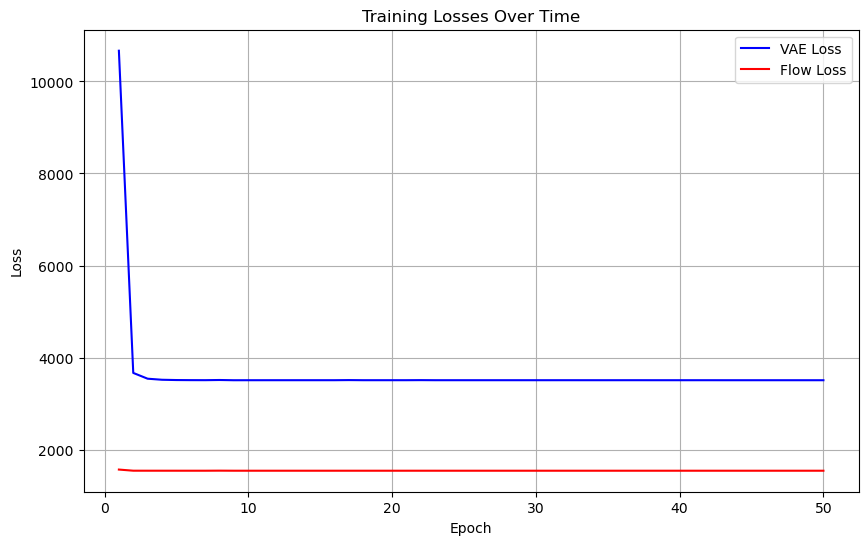

In [168]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, train_vae_losses, label='VAE Loss', color='blue')
plt.plot(epoch_numbers, train_flow_losses, label='Flow Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Save the plot if desired
plt.savefig('training_losses.png')
plt.close()

In [169]:
torch.save(model, 'combined_model_entire.pth')


In [170]:
temperature = 1.0
for i in range(10):
  generate_smiles(model, latent_dim, idx_to_char, char_to_idx, max_length, temperature)

[03:39:26] SMILES Parse Error: unclosed ring for input: 'SNS32on1c5[nH]Ncsn13c[H]4Cl[H][nH]N'
[03:39:26] SMILES Parse Error: syntax error while parsing: (42C13s=
[03:39:26] SMILES Parse Error: check for mistakes around position 1:
[03:39:26] (42C13s=
[03:39:26] ^
[03:39:26] SMILES Parse Error: Failed parsing SMILES '(42C13s=' for input: '(42C13s='
[03:39:26] SMILES Parse Error: extra close parentheses while parsing: OOo2oNs3nBrC35FO1NF3O566)=S[nH]cClS1Cl[H]s55c)4c[nH]S3ClOF)s6ClO3O
[03:39:26] SMILES Parse Error: check for mistakes around position 25:
[03:39:26] oNs3nBrC35FO1NF3O566)=S[nH]cClS1Cl[H]s55c
[03:39:26] ~~~~~~~~~~~~~~~~~~~~^
[03:39:26] SMILES Parse Error: Failed parsing SMILES 'OOo2oNs3nBrC35FO1NF3O566)=S[nH]cClS1Cl[H]s55c)4c[nH]S3ClOF)s6ClO3O' for input: 'OOo2oNs3nBrC35FO1NF3O566)=S[nH]cClS1Cl[H]s55c)4c[nH]S3ClOF)s6ClO3O'
[03:39:26] SMILES Parse Error: extra close parentheses while parsing: FncoBro)3O41CSClCcnC4)1ON1
[03:39:26] SMILES Parse Error: check for mistakes around p